In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers, optimizers

# Methods

`make_sequence` turns the samples into an array of sequential samples of specified length.  
`make_label` adjusts accordingly the corresponding label of each sequential sample.  
`eval_pred` evaluates the predictions of a model by outputting the distance between each prediction to its actual label.

In [2]:
def make_sequence(array, length):
    sequence = []
    for i in range(len(array)-length):
        sequence.append(array[i: (i+length)])
    return np.asarray(sequence)

def make_label(array, offset):
    return np.asarray(array[offset:])
    
def eval_pred(preds, label):
    diff = np.array([])
    for pred in range(len(label)):
        diff = np.append(diff, abs(y_test[pred]-preds[pred]))

    return diff

# Organising Data

In [3]:
df = pd.read_csv('Data Daily/btc-price-iso.csv', engine='python')
df.head()

,timestamp,market-cap,total-btc,n-transactions-avg,block-size-avg(MB),market-price
0,01/04/2019 00:00,7.208649e+10,17620750.0,377350.7143,1.205358,4114.16
1,02/04/2019 00:00,7.276155e+10,17622075.0,382363.8571,1.215507,4152.53
2,03/04/2019 00:00,8.456594e+10,17623412.5,379087.2857,1.248330,4882.88
3,04/04/2019 00:00,8.902573e+10,17624737.5,373510.4286,1.212958,4959.81
4,05/04/2019 00:00,9.259859e+10,17626075.0,375978.0000,1.240969,4911.24


Convert Strings to Datetime.

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df.head()

,timestamp,market-cap,total-btc,n-transactions-avg,block-size-avg(MB),market-price
0,2019-04-01,7.208649e+10,17620750.0,377350.7143,1.205358,4114.16
1,2019-04-02,7.276155e+10,17622075.0,382363.8571,1.215507,4152.53
2,2019-04-03,8.456594e+10,17623412.5,379087.2857,1.248330,4882.88
3,2019-04-04,8.902573e+10,17624737.5,373510.4286,1.212958,4959.81
4,2019-04-05,9.259859e+10,17626075.0,375978.0000,1.240969,4911.24


Break each Datetime down into separate day, month, year columns for easier access.

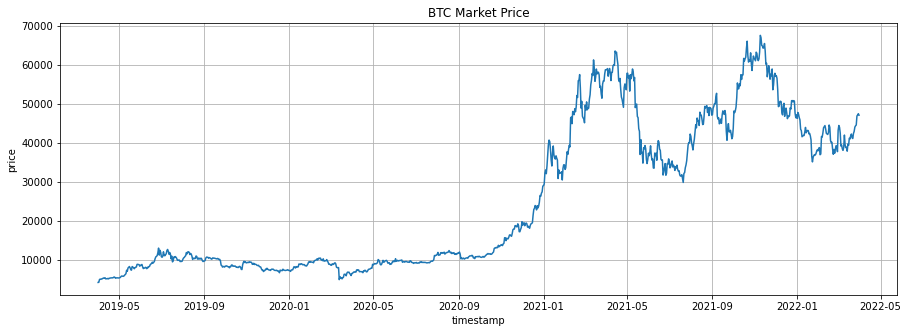

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df.iloc[:]['timestamp'], df.iloc[:]['market-price'])
plt.title('BTC Market Price')
plt.xlabel('timestamp')
plt.ylabel('price')
plt.grid()
plt.show()

# Preparing Data

In [6]:
df.head()

,timestamp,market-cap,total-btc,n-transactions-avg,block-size-avg(MB),market-price
0,2019-04-01,7.208649e+10,17620750.0,377350.7143,1.205358,4114.16
1,2019-04-02,7.276155e+10,17622075.0,382363.8571,1.215507,4152.53
2,2019-04-03,8.456594e+10,17623412.5,379087.2857,1.248330,4882.88
3,2019-04-04,8.902573e+10,17624737.5,373510.4286,1.212958,4959.81
4,2019-04-05,9.259859e+10,17626075.0,375978.0000,1.240969,4911.24


### Scaling Data

In [7]:
scaler = preprocessing.StandardScaler()

# Features to be scaled
scaled_data = scaler.fit_transform(df[['block-size-avg(MB)', 'n-transactions-avg', 'total-btc', 'market-cap', 'market-price']])

Make a copy of the original Dataframe for manipulation.

In [8]:
scaled_df = df.copy()

Replace the features by the scaled version.

In [9]:
scaled_df['block-size-avg(MB)'] = scaled_data[:, 0]
scaled_df['n-transactions-avg'] = scaled_data[:, 1]
scaled_df['total-btc'] = scaled_data[:, 2]
scaled_df['market-cap'] = scaled_data[:, 3]
scaled_df['market-price'] = scaled_data[:, 4]
scaled_df.head()

,timestamp,market-cap,total-btc,n-transactions-avg,block-size-avg(MB),market-price
0,2019-04-01,-0.829039,-1.977428,2.048417,0.191036,-1.099172
1,2019-04-02,-0.826768,-1.973361,2.175777,0.254517,-1.097153
2,2019-04-03,-0.787051,-1.969256,2.092535,0.459827,-1.058729
3,2019-04-04,-0.772045,-1.965190,1.950853,0.238574,-1.054682
4,2019-04-05,-0.760024,-1.961085,2.013542,0.413783,-1.057237


### Splitting the Dataset

In [10]:
training, testing = model_selection.train_test_split(scaled_df, shuffle=False)
print('Dataset size: %d' % (len(scaled_df)))
print('Training size: %d' % (len(training)))
print('Testing size: %d' % (len(testing)))

Dataset size: 1096
Training size: 822
Testing size: 274


Select relevant features to train and test.

In [11]:
X_train = training[['market-price', 'block-size-avg(MB)', 'n-transactions-avg', 'total-btc', 'market-cap']].to_numpy()
y_train = training['market-price'].to_numpy()

In [12]:
X_test = testing[['market-price', 'block-size-avg(MB)', 'n-transactions-avg', 'total-btc', 'market-cap']].to_numpy()
y_test = testing['market-price'].to_numpy()

See data train and test.

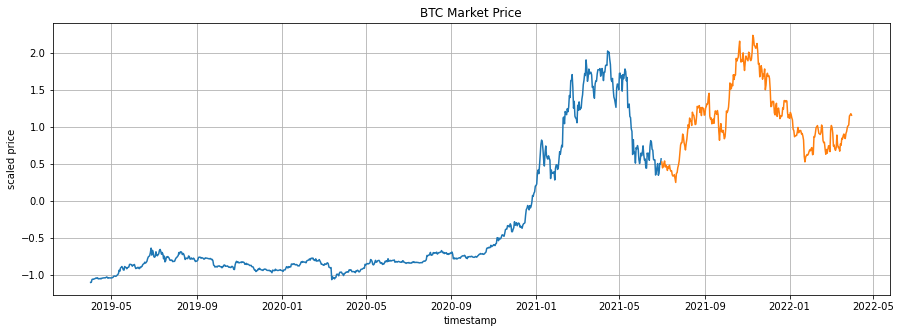

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(training['timestamp'], X_train[:, 0])
plt.plot(testing['timestamp'], X_test[:, 0])
plt.xlabel('timestamp')
plt.ylabel('scaled price')
plt.title('BTC Market Price')
plt.grid()
plt.show()

### Making Each Sample Sequential

In [14]:
length = 8

In [15]:
X_train = make_sequence(X_train, length)
X_test  = make_sequence(X_test, length)
y_train = make_label(y_train, length)
y_test = make_label(y_test, length)

After some slicing,   
`X_train` shape: `(814, 8, 5)`  
`y_train` shape: `(814, )`   
`X_test` shape: `(266, 8, 5)`  
`X_train` shape: `(266, )`

See data for one sequence with its corresponding label which the price for the next timestamp.

In [16]:
# plt.figure(figsize=(15, 5))
# plt.plot(training[0: 8]['timestamp'], X_train[0, :, 0])
# plt.scatter(training[8: 9]['timestamp'], y_train[0], marker='o', color='red')
# plt.title('BTC Market Price for One Sequence')
# plt.xlabel('timestamp')
# plt.ylabel('scaled price')
# plt.grid()
# plt.show()

# Building Models

## LSTM

Choose an optimiser for the model.

In [17]:
optim = optimizers.Adagrad()

Start building an LSTM model.

In [18]:
lstm = tf.keras.Sequential()
lstm.add(layers.LSTM(64, return_sequences=True))
lstm.add(layers.Dropout(0.5))
lstm.add(layers.LSTM(20,return_sequences=False))
lstm.add(layers.Dropout(0.5))
lstm.add(layers.Dense(1))
lstm.compile(loss='mse', optimizer=optim)

Train the model.

In [19]:
lstm.fit(X_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
26/26 [==============================] - 6s 4ms/step - loss: 0.8633
Epoch 2/200
26/26 [==============================] - 0s 4ms/step - loss: 0.8173
Epoch 3/200
26/26 [==============================] - 0s 4ms/step - loss: 0.7889
Epoch 4/200
26/26 [==============================] - 0s 4ms/step - loss: 0.7591
Epoch 5/200
26/26 [==============================] - 0s 4ms/step - loss: 0.7395
Epoch 6/200
26/26 [==============================] - 0s 5ms/step - loss: 0.7195
Epoch 7/200
26/26 [==============================] - 0s 3ms/step - loss: 0.7029
Epoch 8/200
26/26 [==============================] - 0s 3ms/step - loss: 0.6741
Epoch 9/200
26/26 [==============================] - 0s 3ms/step - loss: 0.6677
Epoch 10/200
26/26 [==============================] - 0s 3ms/step - loss: 0.6458
Epoch 11/200
26/26 [==============================] - 0s 3ms/step - loss: 0.6329
Epoch 12/200
26/26 [==============================] - 0s 3ms/step - loss: 0.6219
Epoch 13/200
26/26 [=================

26/26 [==============================] - 0s 3ms/step - loss: 0.1785
Epoch 102/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1679
Epoch 103/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1738
Epoch 104/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1763
Epoch 105/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1688
Epoch 106/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1664
Epoch 107/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1598
Epoch 108/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1677
Epoch 109/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1789
Epoch 110/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1659
Epoch 111/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1456
Epoch 112/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1672
Epoch 113/200
26/26 [=========

In [20]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 64)             17920     
_________________________________________________________________
dropout (Dropout)            (None, 2, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                6800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 24,741
Trainable params: 24,741
Non-trainable params: 0
_________________________________________________________________


### Evaluation

The following array is the predictions the model has made given test samples.

In [21]:
preds_test_lstm = lstm.predict(X_test)

In [22]:
diff = eval_pred(preds_test_lstm, y_test)
print('Average test difference: %.2f' % (diff.mean()))

Average test difference: 0.31


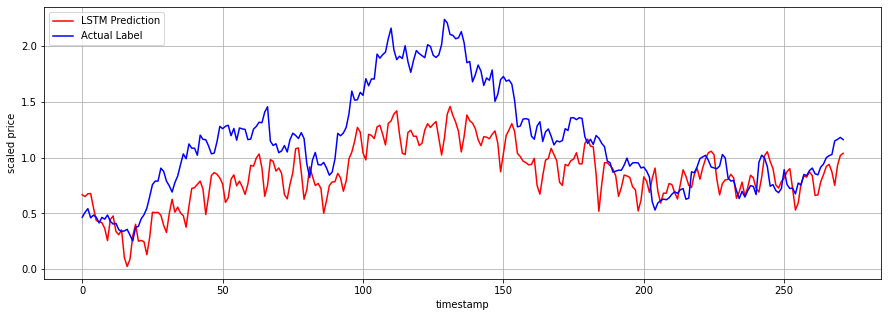

In [23]:
plt.figure(figsize=(15, 5))

plt.plot(preds_test_lstm, color='red', label='LSTM Prediction')
plt.plot(y_test, color='blue', label='Actual Label')
plt.xlabel('timestamp')
plt.ylabel('scaled price')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Bidirectional LSTM

Build a bidirectional LSTM model, very similar to the LSTM above, except a bidirectional layer is added.

In [24]:
bi_lstm = tf.keras.Sequential()
bi_lstm.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
bi_lstm.add(layers.Dropout(0.5))
bi_lstm.add(layers.Bidirectional(layers.LSTM(20, return_sequences=False)))
bi_lstm.add(layers.Dropout(0.5))
bi_lstm.add(layers.Dense(1))
bi_lstm.compile(loss='mse', optimizer=optim)

In [25]:
bi_lstm.fit(X_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
26/26 [==============================] - 11s 4ms/step - loss: 0.8041
Epoch 2/200
26/26 [==============================] - 0s 4ms/step - loss: 0.7555
Epoch 3/200
26/26 [==============================] - 0s 4ms/step - loss: 0.7016
Epoch 4/200
26/26 [==============================] - 0s 4ms/step - loss: 0.6664
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 0.6311
Epoch 6/200
26/26 [==============================] - 0s 5ms/step - loss: 0.6029
Epoch 7/200
26/26 [==============================] - 0s 4ms/step - loss: 0.5713
Epoch 8/200
26/26 [==============================] - 0s 5ms/step - loss: 0.5484
Epoch 9/200
26/26 [==============================] - 0s 4ms/step - loss: 0.5247
Epoch 10/200
26/26 [==============================] - 0s 4ms/step - loss: 0.4958
Epoch 11/200
26/26 [==============================] - 0s 4ms/step - loss: 0.4843
Epoch 12/200
26/26 [==============================] - 0s 5ms/step - loss: 0.4540
Epoch 13/200
26/26 [================

26/26 [==============================] - 0s 4ms/step - loss: 0.0945
Epoch 103/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0947
Epoch 104/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0996
Epoch 105/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1051
Epoch 106/200
26/26 [==============================] - 0s 4ms/step - loss: 0.1008
Epoch 107/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0963
Epoch 108/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0944
Epoch 109/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0950
Epoch 110/200
26/26 [==============================] - 0s 4ms/step - loss: 0.1016
Epoch 111/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0940
Epoch 112/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0905
Epoch 113/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0954
Epoch 114/200
26/26 [=========

In [26]:
bi_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2, 128)            35840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                23840     
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 59,721
Trainable params: 59,721
Non-trainable params: 0
_________________________________________________________________


### Evaluation

In [27]:
preds_test_blstm = bi_lstm.predict(X_test)

In [28]:
bi_diff = eval_pred(preds_test_blstm, y_test)
print('Average difference: %.2f' % (bi_diff.mean()))

Average difference: 0.22


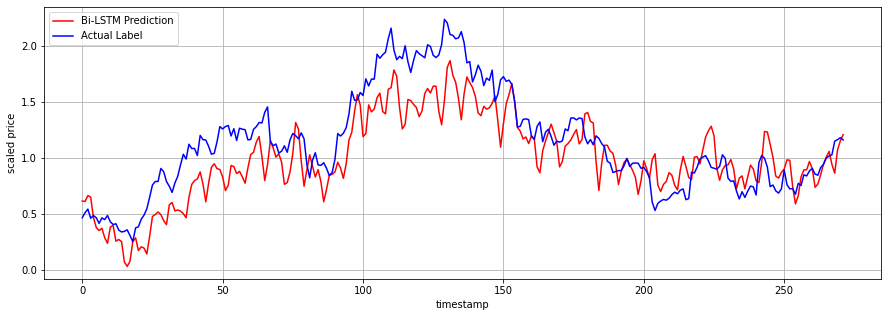

In [29]:
plt.figure(figsize=(15, 5))

plt.plot(preds_test_blstm, color='red', label='Bi-LSTM Prediction')
plt.plot(y_test,color='blue', label='Actual Label')
plt.xlabel('timestamp')
plt.ylabel('scaled price')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## GRU

Here, we are building a Gated Recurrent Unit model, using almost same configurations as the above models.

In [30]:
gru = tf.keras.Sequential()
gru.add(layers.GRU(64, return_sequences=True))
gru.add(layers.Dropout(0.5))
gru.add(layers.GRU(20, return_sequences=False))
gru.add(layers.Dropout(0.5))
gru.add(layers.Dense(1))
gru.compile(loss='mse', optimizer=optim)

In [31]:
gru.fit(X_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
26/26 [==============================] - 6s 3ms/step - loss: 0.6115
Epoch 2/200
26/26 [==============================] - 0s 3ms/step - loss: 0.4437
Epoch 3/200
26/26 [==============================] - 0s 3ms/step - loss: 0.4047
Epoch 4/200
26/26 [==============================] - 0s 4ms/step - loss: 0.3358
Epoch 5/200
26/26 [==============================] - 0s 3ms/step - loss: 0.3074
Epoch 6/200
26/26 [==============================] - 0s 4ms/step - loss: 0.2993
Epoch 7/200
26/26 [==============================] - 0s 4ms/step - loss: 0.2753
Epoch 8/200
26/26 [==============================] - 0s 4ms/step - loss: 0.2602
Epoch 9/200
26/26 [==============================] - 0s 3ms/step - loss: 0.2572
Epoch 10/200
26/26 [==============================] - 0s 3ms/step - loss: 0.2565
Epoch 11/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2438
Epoch 12/200
26/26 [==============================] - 0s 6ms/step - loss: 0.2312
Epoch 13/200
26/26 [=================

26/26 [==============================] - 0s 4ms/step - loss: 0.0930
Epoch 103/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1050
Epoch 104/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0940
Epoch 105/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0897
Epoch 106/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0936
Epoch 107/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1013
Epoch 108/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1045
Epoch 109/200
26/26 [==============================] - 0s 4ms/step - loss: 0.1019
Epoch 110/200
26/26 [==============================] - 0s 5ms/step - loss: 0.1009
Epoch 111/200
26/26 [==============================] - 0s 4ms/step - loss: 0.1040
Epoch 112/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1092
Epoch 113/200
26/26 [==============================] - 0s 4ms/step - loss: 0.1013
Epoch 114/200
26/26 [=========

In [32]:
gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2, 64)             13632     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                5160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 18,813
Trainable params: 18,813
Non-trainable params: 0
_________________________________________________________________


### Evaluation

In [33]:
preds_test_gru = gru.predict(X_test)

In [34]:
gru_diff = eval_pred(preds_test_gru, y_test)
print('Average difference: %.2f' % (gru_diff.mean()))

Average difference: 0.36


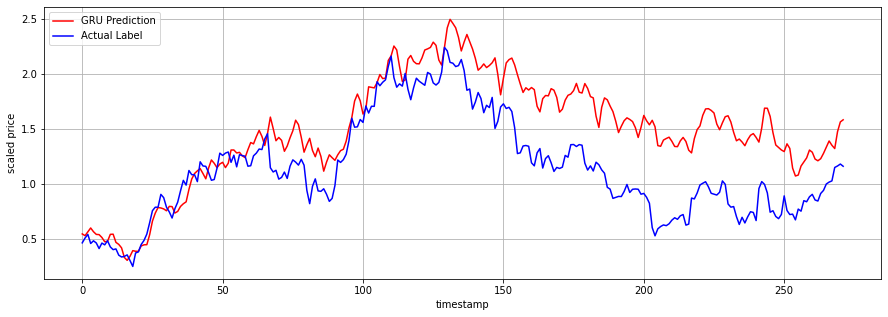

In [35]:
plt.figure(figsize=(15, 5))

plt.plot(preds_test_gru, color='red', label='GRU Prediction')
plt.plot(y_test,color='blue', label='Actual Label')
plt.xlabel('timestamp')
plt.ylabel('scaled price')
plt.legend(loc='upper left')
plt.grid()
plt.show()